Velg datasett (plateau / gaussian / sinusoidal):


>>  plateau


Episode 1, Total Loss: 10.3879
Episode 2, Total Loss: 13.0772
Episode 3, Total Loss: 13.6369
Episode 4, Total Loss: 13.0145
Episode 5, Total Loss: 11.8788
Episode 6, Total Loss: 9.1638
Episode 7, Total Loss: 6.4290
Episode 8, Total Loss: 4.6149
Episode 9, Total Loss: 3.5829
Episode 10, Total Loss: 3.1213
Episode 11, Total Loss: 2.8505
Episode 12, Total Loss: 2.8651
Episode 13, Total Loss: 2.5131
Episode 14, Total Loss: 2.6530
Episode 15, Total Loss: 2.6101
Episode 16, Total Loss: 2.3905
Episode 17, Total Loss: 2.6892
Episode 18, Total Loss: 2.3116
Episode 19, Total Loss: 2.6738
Episode 20, Total Loss: 2.5718


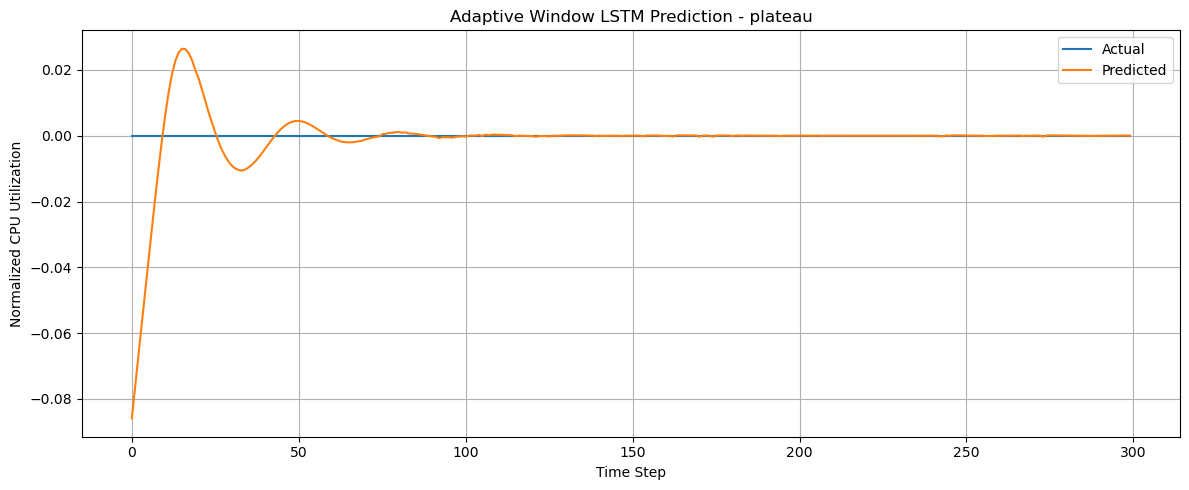

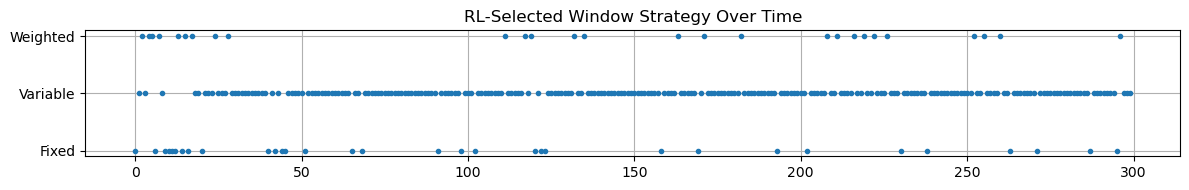

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/adaptive_all_commented_fixed.py'

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === STEP 1: Ask user which dataset to use ===
print("Velg datasett (plateau / gaussian / sinusoidal):")
choice = input(">> ").strip().lower()

# Map each user choice to a file
file_map = {
    "plateau": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Plateu/plateau_log.csv",
    "gaussian": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Gausian curve/gaussian_curve_fixed.csv",
    "sinusoidal": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/sinusoid curve/sinusoidal_log.csv"
}

# Validate input
if choice not in file_map:
    print("Ugyldig valg.")
    exit()

filename = file_map[choice]
if not os.path.exists(filename):
    print(f"Filen '{filename}' ble ikke funnet i mappen.")
    exit()

# === STEP 2: Load and normalize the data ===
df = pd.read_csv(filename)  # Expect columns: X and Y
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[['Y']].values).astype(np.float32)

# === STEP 3: Define the three windowing strategies ===

# Fixed-size sliding window (e.g. 20 steps)
def fixed_window(data, idx, size=20):
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

# Variable-length window (random size between 10-30)
def variable_window(data, idx, min_size=10, max_size=30):
    size = random.randint(min_size, max_size)
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

# Weighted window (weights grow from 0.1 to 1.0)
def weighted_window(data, idx, size=20):
    if idx < size: window = data[0:idx+1]
    else: window = data[idx-size+1:idx+1]
    weights = np.linspace(0.1, 1.0, len(window)).reshape(-1, 1)
    return window * weights

# === STEP 4: Define the LSTM model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# === STEP 5: Initialize model and RL components ===
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Q-values for [fixed, variable, weighted]
Q = np.zeros((3,))
epsilon = 0.2  # exploration rate
alpha = 0.1    # learning rate
gamma = 0.9    # discount factor

# === STEP 6: Training loop ===
episodes = 20  # number of training epochs
predictions, actuals, actions_taken = [], [], []

for ep in range(episodes):
    total_loss = 0
    for t in range(30, len(normalized)-1):
        # Choose action: explore or exploit
        if random.random() < epsilon:
            action = random.randint(0, 2)
        else:
            action = int(np.argmax(Q))

        # Get input window based on chosen strategy
        if action == 0:
            window = fixed_window(normalized, t)
        elif action == 1:
            window = variable_window(normalized, t)
        else:
            window = weighted_window(normalized, t)

        # Convert input to tensor with correct shape
        x = torch.tensor(window, dtype=torch.float32)
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)

        y_true = torch.tensor(normalized[t+1], dtype=torch.float32).unsqueeze(0)

        # Predict with LSTM
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true)
        total_loss += loss.item()

        # Train the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Reward = negative loss (we want low error)
        reward = -loss.item()

        # Update Q-value for the strategy used
        Q[action] = Q[action] + alpha * (reward + gamma * np.max(Q) - Q[action])

        # Save results for plotting
        predictions.append(y_pred.item())
        actuals.append(y_true.item())
        actions_taken.append(action)

    print(f"Episode {ep+1}, Total Loss: {total_loss:.4f}")

# === STEP 7: Plot predictions ===
plt.figure(figsize=(12, 5))
plt.plot(actuals[:300], label='Actual')
plt.plot(predictions[:300], label='Predicted')
plt.title(f"Adaptive Window LSTM Prediction - {choice}")
plt.xlabel("Time Step")
plt.ylabel("Normalized CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 8: Plot RL window choices over time ===
plt.figure(figsize=(12, 2))
plt.plot(actions_taken[:300], '.', label='Action (0=Fixed, 1=Variable, 2=Weighted)')
plt.yticks([0, 1, 2], ['Fixed', 'Variable', 'Weighted'])
plt.title("RL-Selected Window Strategy Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# Lagre scriptet
adaptive_script_path = "/mnt/data/adaptive_all_commented_fixed.py"
with open(adaptive_script_path, "w") as f:
    f.write(adaptive_script)

adaptive_script_path